# Predicting electricity load for intraday market in Germany 

This project is to predict electricity demand 30 minutes before the delivery time for the intraday market trading in Germany by using historical data of the total load offered by [ENTSO-E Transparency platform](https://transparency.entsoe.eu/).

Aim
- learn how to build a LSTM model to predict time series data
- experiment the model with various input values and interpret the results
- understand the difficulty of prediction in short-term electricity market

Data
- includes actual aggregated total load and day-ahead forecast load in Germany
- 15 minutes time step
- The data in 2015 is used to train the model by splitting into train and validation sets and the data in 2016 is used to test the model. The starting step and the duration of testing can be selected.

Model
- Long Short Term Memory networks (LSTMs) model is used to predict the load. It is a special kind of an artificial recurrent neural networks, capable of learning long-term dependencies. It is a popular model in forecasting power consumption such as for [household power consumption](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba) and [forecasting hourly power demand in Spain](https://www.kaggle.com/nicholasjhana/univariate-time-series-forecasting-with-keras/data). This project has developed while referring to these examples. 

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping




Bad key "text.kerning_factor" on line 4 in
C:\Users\Haeyun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


# 1. Data Preparation


## Process raw data

In [2]:
# read csv file and parse the datetime
def date_parser(t):
    """
    * parameters
    - t: (str) text of datetime duration from the raw data
    * return
    -  datetime object 
    """
    time = t.split('-')[0][:-1] # e.g. '01.01.2015 00:00'
    return datetime.strptime(time,'%d.%m.%Y %H:%M')

def process_rawdata(fileName,usecol= 'Actual Total Load [MW] - Germany (DE)',extra_cols=False):
    """
    * It translates csv file into DataFrame which are to used for model development.
    * parmeters
    - fileName: (str) name of the file without .csv domain
    - usecol: Default is total load. For day-ahead dataframe, 
                define usecol as "Day-ahead Total Load Forecast [MW] - Germany (DE)"
    - extra_cols: (boolean) if extra columns are required or not, default: False
    
    return
    - DataFrame: cols = ['Datetime','Load','month','date','time']
    """
    df = pd.read_csv('input/%s.csv'%fileName,
                       usecols= ['Time (CET)',usecol], # columns to use
                       parse_dates=['Time (CET)'], date_parser=date_parser)

    df.columns = ['Datetime','Load'] # change column names
    
    # there are NaN values due to an hour skipping on the starting day of summer time
    print("The number of NaN values are %d due to the start of summer time."%df['Load'].isnull().sum())
    df = df.dropna() #nan values are skipped summer time hour 
    print("Now, the number of NaN values is %d by deleting the skipped hour."%df['Load'].isnull().sum())
    
    
    # add year, month, date, time columns to allow us to group the data by these parameters 
    #df['year'] = df['Datetime'].apply(lambda x: x.year)
    if extra_cols:
        df['month'] = df['Datetime'].apply(lambda x: x.month)
        df['date'] = df['Datetime'].apply(lambda x: x.date())
        df['time'] = df['Datetime'].apply(lambda x: x.time())

    return df

#load = process_rawdata('Load_2015')
#load.head()

# 2. Data visualization
In this section, data will be simply visualized in order to examine load profile.

## Heatmap 
- Heatmap of load values by date and time dimensions can show the pattern of load over the year (date) and the day (time)

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.


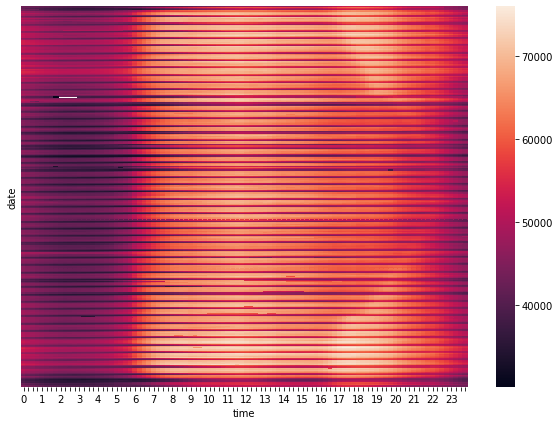

In [3]:
import seaborn as sns

load = process_rawdata('Load_2015',extra_cols=True)

# create a pivot table by date and time 
matrixLoad = load.pivot_table(values='Load',index='date',columns='time')
plt.figure(figsize=(10,7))

x_heatmap_label = [] # label for hours
for i in range(0,24):
    x_heatmap_label.append(i)
    for i in range(3):
        x_heatmap_label.append('')

sns.heatmap(matrixLoad,xticklabels=x_heatmap_label,yticklabels=False)#vmax=0.1,vmin=-0.1,
#plt.savefig('output/heatmap.png')

Interpretation
- Until around 6, electricity consumption is lower during the day but it is slightly higher in winter time compared to summer time.
- Between 16 and 22, there is a curve pattern, which shows load changes in the evening depending on sunset time. (less light, less heating ...)
- The white blank on the top left indicates the skipped summer hour. 

## Plotting timeseries

Text(0, 0.5, 'Mean Total Load')

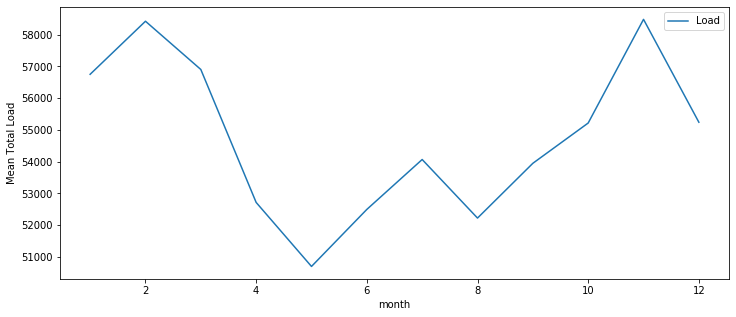

In [4]:
dfp = load.groupby(by='month').mean()
dfp.plot(figsize=(12,5))

plt.ylabel('Mean Total Load')

The mean load of each month is plotted above. As we expected from the heatmap, summer time has less electricity consumption. 
Next, we will plot time series of the month that has the lowest (May) and the highest (November) load.

Text(0, 0.5, 'Total Load')

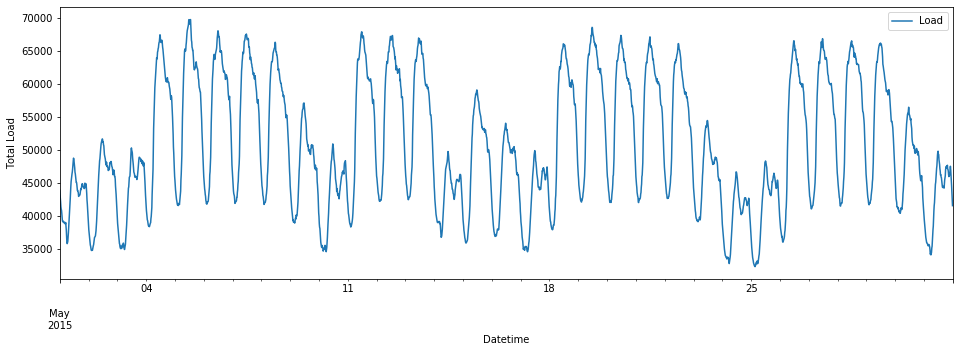

In [5]:
dfp = load[load['month']== 5][['Datetime','Load']]
dfp.set_index('Datetime',inplace=True)
dfp.plot(figsize=(16,5))

plt.ylabel('Total Load')

Text(0, 0.5, 'Total Load')

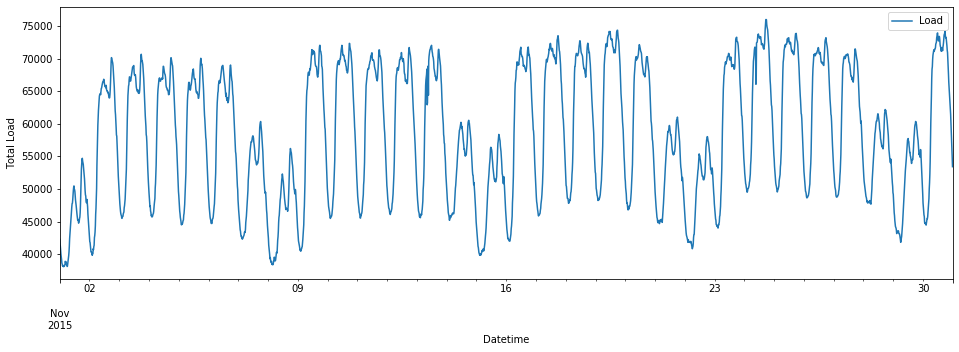

In [6]:
dfp = load[load['month']== 11][['Datetime','Load']]
dfp.set_index('Datetime',inplace=True)
dfp.plot(figsize=(16,5))

plt.ylabel('Total Load')

The weekly pattern seems similar between May and November, but there is difference the daily pattern.

Next, we will analyze the data in statistical approach. 

# 3. Data analysis - decomposition, autocorrelation

## Decompose the time series and analyze the systematic components - Trend, Seasonal, Residual

Decomposition of single value is widely used to analyze time series data. It consists of Trend, Seasonal and Residual.

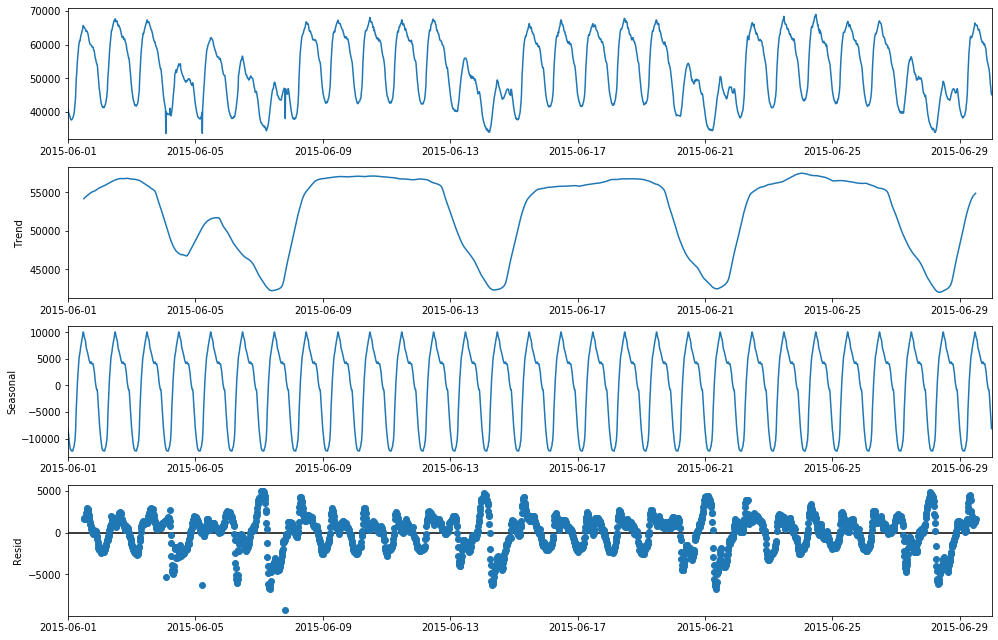

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

dfp = load[['Datetime','Load']]
dfp.set_index('Datetime',inplace=True)
dfp.index
decompose = seasonal_decompose(dfp.loc[datetime(2015,6,1,0,0):datetime(2015,6,30,0,0),:],period=96)

plt.rcParams['figure.figsize'] = (14, 9)
decompose_plot = decompose.plot()

The time series of June is decomposed with the period of 24 hours. 
- Trend shows weekly pattern of the month while seasonal components captures the daily pattern.
- Residual is considered as noise which is random variation. However, residual itself seems has its own periodic pattern. In order not to jump to conclusion, another month is decomposed below (Dec): it shows periodic ups and downs as well.

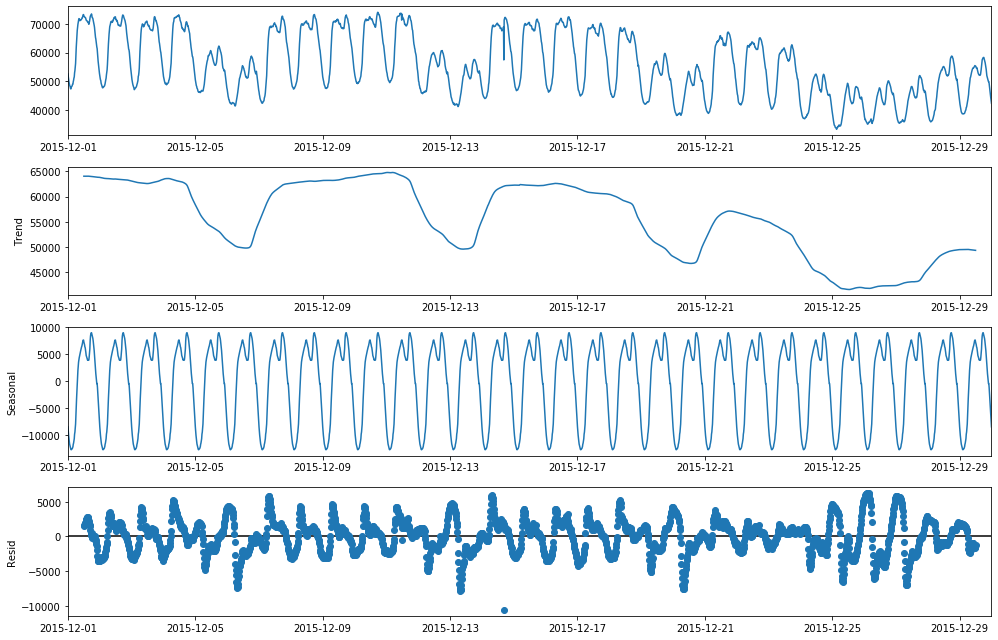

In [9]:
decompose = seasonal_decompose(dfp.loc[datetime(2015,12,1,0,0):datetime(2015,12,30,0,0),:],period=96)

plt.rcParams['figure.figsize'] = (14, 9)
decompose_plot = decompose.plot()

## Autocorrelation and Partial Autocorrelation

Autocorrelation (AC) is the correlation between the series and its past values. Unlike correlation, autocorrelation compares the same parameter but in different (past) time. So, it can show how the given time value is related to the past time (lag) values.

Partial autocorrelation (PAC) is defined as "The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags." ([Reference](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)). Simply, PAC gives the correlation of residuals (errors) from the best fit line ([video tutorial](https://www.youtube.com/watch?v=ZjaBn93YPWo)).  

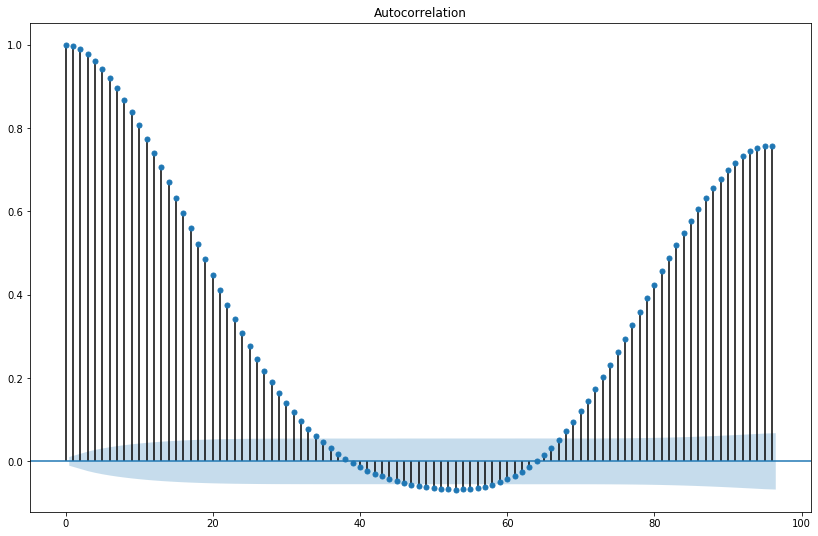

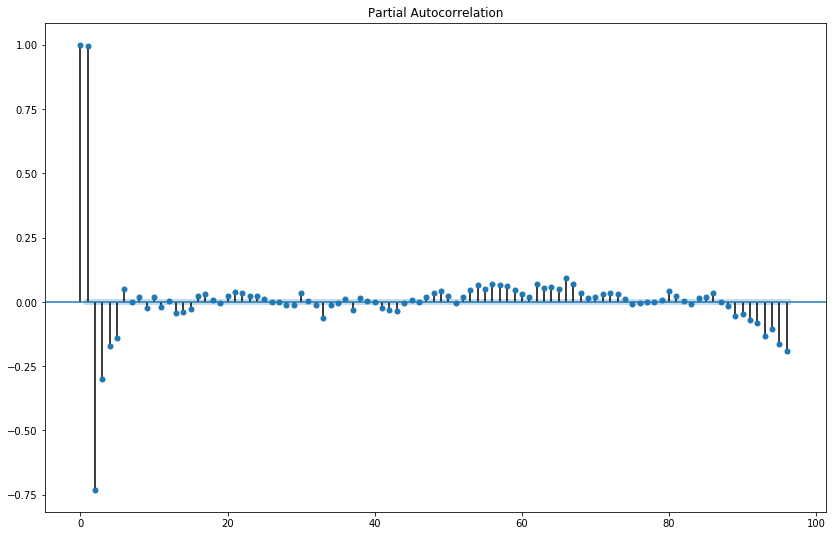

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf = plot_acf(dfp['Load'],lags=4*24*1)
plot_pacf = plot_pacf(dfp['Load'],lags=4*24*1)

Correlogram shows strong periodic correlation (24 hours: 96 steps). This periodic plot of AC can be interpreted as the daily consumption pattern.
From the partial-correlogram, we can obtain direct correlations of past time values. The residuals after capturing trend and seasonal are highly correlated upto 5 time steps.

- The 5 time steps look back will have a great impact on predicting the given step

# 3. Processing Data
A class ProcessData is created in order to process data into supervised learning datasets. 

## 1) Normalization
- The features for LSTM model should be normalized. 
- MinMaxScaler from sklearn is used as a scaler.

## 2) Convert series into labeled datasets
- In order to train the LSTM model, the time sequence must be converted into labled datasets. It means that the array of input values X and output value y should be defined. Input X is the past (lagged) values, and y is the load value at the target time.  

## 3) Split into training and validation sets
- The converted dataset is split into train and validation sets.

In [11]:
class ProcessData:
    
    def __init__(self,dfLoad, test=False, test_start=0, test_days=2):
        """
        1) Normalization
        * parameters
        - dfLoad: (DataFrame) load data
        - test: (boolean) If the data processing is for test sets or not, default: False
        - test_start: (int) timestep where the test dataset starts
        - test_days: (int) duration of the test set in days
        
        * attributes
        - scaler: (scaler object) 
        - data: (array) normalized load data
        """
        self.scaler = MinMaxScaler()
        
        if not test:
            self.data = dfLoad.Load.values #np.array
            
        else:
            self.data = dfLoad.Load.values[test_start:test_start+4*24*test_days]
            
            
        self.data = np.reshape(self.data,(-1,1)) # -1 infers the length of the array
        self.data = self.scaler.fit_transform(self.data)
    
    def split_series(self,dataset,lags,before=2):
        """
        2) Convert series into labled datasets
        * parameters
        - dataset: (array) normalized time series 
        - lags: (int) the number of time steps to look back, which will be used as an input of LSTM model
                :default: 12 (4 hours)
        - before: (int) the number of time steps before which given time value should be predicted. 
                : default: 2 (indicates 30 min which is the last minute of trading in intraday market in Germany)
        
        * return
        - X, y: (array) input and lable data 
        """
        if len(dataset) < (lags + before):
            print("Data is not enough to create sequence split.")
            sys.exit()
        
        X, y = list(), list()
        
        
        for i in range(len(dataset)):
            
            i_target = i + lags + before # index of target time
            
            slice = dataset[i:i_target-before,0] # selecting the number of lags upto 30 minutes before given (target) time
            
            if i_target > len(dataset)-1:
                break
            
            X.append(slice)
            y.append(dataset[i_target,0])
            
        
        X = np.array(X)
        X = np.reshape(X, (X.shape[0], X.shape[1],1))
        # shape [# lags, # samples, # features ]
        
        y = np.array(y)
                
        return X, y
    
    def train_val_split(self, lags,train_size=0.80,before=2):
        """
        3) Split into training and validation dataset
        
        * parameters
        - lags: (int)
        - train_size: (float) range between 0 and 1, default 0.80
        - before: (int)
        
        * attributes
        - X_train, y_train, X_val, y_val (array)
        """
        train_len = int(len(self.data)*train_size)
        train, val = self.data[:train_len,:], self.data[train_len:len(self.data),:]
        
        self.X_train, self.y_train = self.split_series(train, lags, before=before)
        self.X_val, self.y_val = self.split_series(val,lags,before=before)
        
        #self.X_train = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1],1))
        #self.X_val = np.reshape(self.X_val, (self.X_val.shape[0], self.X_val.shape[1],1))
        

    


# 4) Define the LSTM model

In [12]:
def lstm_model(cells=50,lags=12,drop_out=True):
    """
    * parameters
    - cells: (int) no. of cells for LSTM
    - lags: (int)
    - drop_out: (boolean) adding Dropout or not, drop out can prevent overfitting as a regularization method
    
    * return
    - model: (Sequential object)
    """
    model = Sequential()

    model.add(LSTM(cells,activation='relu',input_shape=(lags,1))) # one feature
    if drop_out:
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam')

    return model

# 5) Experiments
By using the ProcessData class and LSTM model architecture function, the following class ExperimentForecast allows us to experiment forecasting model on various settings such as data year and lags. With this class, we will experiement some occasions and talk about the result.

In [15]:
class ExperimentForecast:
    
    def __init__(self,lags,before=2,cells=50,train_year=2015,drop_out=True):
        """
        * parameters
        - lags 
        - before
        - cells
        - train_year: (int) the year of train data
        - drop_out: (boolean) option for Dropout
        
        * attributes
        - lags
        - before
        - ds: (ProcessData object)
        - model: (Sequential object) from the function lstm_model
        """
        self.lags = lags
        self.before = before
        
        fileName = 'Load_%d'%train_year
        load = process_rawdata(fileName)
        self.ds = ProcessData(load)
        self.ds.train_val_split(self.lags,before=self.before)
        
        self.model= lstm_model(cells=cells,lags=self.lags,drop_out=drop_out)
        

    def fit_predict_train(self,epochs=20):
        """
        * parameters
        - epochs: (int) no. of epochs of training lstm model
        
        * attributes
        - history: (History object) saves the history of fitting model parameters such as train and test losses
        - predict_train: (array) result of prediction from training dataset, the values are inversely transformed from normalization
        - predict_val: (array) result of prediction from validation dataset, the values are inversely transformed from normalization
        - y_train: (array) training output values, which is inversely transformed from normalization
        - y_val: (array) validation output values, which is inversely transformed from normalization
        - rmsqrt_train: (float) Train Root Mean Squared Error
        - rmsqrt_val: (float) Validation Root Mean Squared Error
        
        """
        self.history = self.model.fit(self.ds.X_train, self.ds.y_train, epochs=epochs, batch_size=70, validation_data=(self.ds.X_val, self.ds.y_val), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
        
        self.predict_train = self.model.predict(self.ds.X_train)
        self.predict_val = self.model.predict(self.ds.X_val)
        
        self.predict_train = self.ds.scaler.inverse_transform(self.predict_train)
        self.predict_val = self.ds.scaler.inverse_transform(self.predict_val)
        
        self.y_train = self.ds.scaler.inverse_transform([self.ds.y_train])
        self.y_val = self.ds.scaler.inverse_transform([self.ds.y_val])
        
        self.rmsqrt_train = np.sqrt(mean_squared_error(self.y_train[0], self.predict_train[:,0]))
        self.rmsqrt_val = np.sqrt(mean_squared_error(self.y_val[0],self.predict_val[:,0]))
        
        print('Train Root Mean Squared Error:',self.rmsqrt_train)
        print('Validation Root Mean Squared Error:',self.rmsqrt_val)
        
    def plot_model_loss(self):
        """
        plots the loss of train and val sets by epochs
        """
        plt.figure(figsize=(8,4))
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Test Loss')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend(loc='upper right')
        
    def model_predict_test(self,test_year=2016,test_start=0,test_days=3):
        """
        process the test data and predict the load by using model trained in the ExperimentForecast instance.
        * parmeters
        - test_year: (int)
        - test_start: (int)
        - test_days: (int)
        
        * attributes
        - ds_test: (ProcessData object)
        - X_test, y_test: (array) 
        - predict_test: (array)
        - y_test: (array)
        - rmsqrt_test: (float)
        """
        
        fileName = 'Load_%d'%test_year
        load = process_rawdata(fileName)
        self.ds_test = ProcessData(load,test=True, test_start=test_start,test_days=test_days)
        
        self.X_test, self.y_test = self.ds_test.split_series(self.ds_test.data, self.lags,before=self.before)
        self.predict_test = self.model.predict(self.X_test)
        
        self.predict_test = self.ds_test.scaler.inverse_transform(self.predict_test)
        self.y_test = self.ds_test.scaler.inverse_transform([self.y_test])
        
        self.rmsqrt_test = np.sqrt(mean_squared_error(self.y_test[0], self.predict_test[:,0]))
        print('Test Root Mean Squared Error:', self.rmsqrt_test)

    def plot_predict_comparison(self):
    
        t = range(len(self.y_test[0])-self.lags)

        plt.figure(figsize=(15,8));
        plt.plot(t,self.y_test[0,self.lags:],label='actual');
        plt.plot(t,self.predict_test[self.lags:,0],label='prediction')
        plt.legend()
 

### Experiment 1
First, we will predict load with the data starting from the one time step before the target, which means before argument is 0. Also, we will not consider Dropout option. 6-timestep of lags is selected as the partial correlogram showed that the first 5 lags have a strong correlation. 
- lags: 6
- before: 0

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28026 samples, validate on 7002 samples
Epoch 1/20
28026/28026 [==============================] - 3s 120us/step - loss: 0.0133 - val_loss: 0.0015
Epoch 2/20
28026/28026 [==============================] - 3s 102us/step - loss: 7.9745e-04 - val_loss: 7.1627e-04
Epoch 3/20
28026/28026 [==============================] - 3s 110us/step - loss: 4.7155e-04 - val_loss: 4.8431e-04
Epoch 4/20
28026/28026 [==============================] - 3s 115us/step - loss: 4.2912e-04 - val_loss: 4.2854e-04
Epoch 5/20
28026/28026 [==============================] - 3s 115us/step - loss: 3.7669e-04 - val_loss: 3.8692e-04
Epoch 6/20
28026/28026 [==============================] - 3s 104us/step - loss: 3.5841e-04 - val_loss: 3.7882e-04
Epoch 7/20
28026/28026 [==============================] - 3s 101us/step - loss: 3.5262e-04 - val_loss: 3.5880e-04
Epoch 8/20
28026/28026 [========

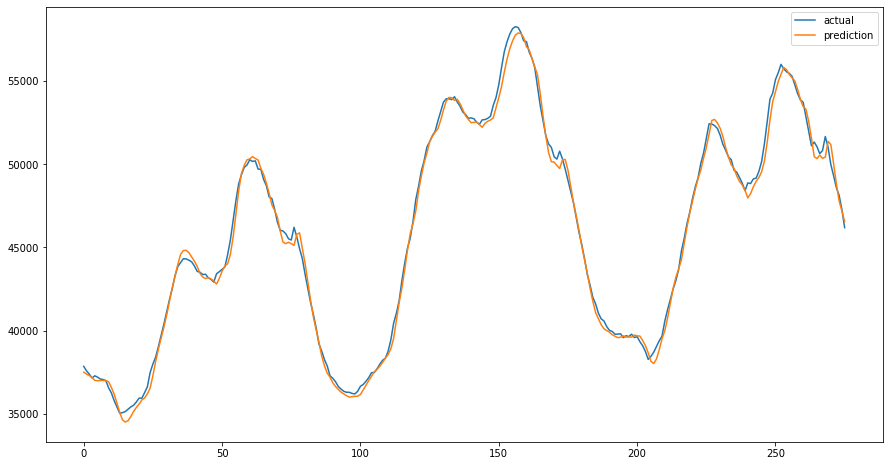

In [16]:
experiment1 = ExperimentForecast(6,before=0,drop_out=False)
experiment1.fit_predict_train()
experiment1.model_predict_test()
experiment1.plot_predict_comparison()

The model with the first settings shows pretty good prediction with 451 RMSE for test set. However, 15 minutes before the prediction is not applicable in intraday market as the electricity is traded 30 minutes before the delivery. Considering the delay of receiving data for each time step, we will assume that the prediction should be completed 45 minutes before the delivery. Thus, before argument will be 2. From the next experiments.

### Experiment 2
- lags: 6
- before: 2

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28024 samples, validate on 7000 samples
Epoch 1/20
28024/28024 [==============================] - 3s 118us/step - loss: 0.0107 - val_loss: 0.0057
Epoch 2/20
28024/28024 [==============================] - 3s 114us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 3/20
28024/28024 [==============================] - 3s 123us/step - loss: 0.0023 - val_loss: 0.0037
Epoch 4/20
28024/28024 [==============================] - 3s 113us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/20
28024/28024 [==============================] - 3s 107us/step - loss: 0.0017 - val_loss: 0.0027
Epoch 6/20
28024/28024 [==============================] - 3s 101us/step - loss: 0.0016 - val_loss: 0.0025
Epoch 7/20
28024/28024 [==============================] - 3s 95us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/20
28024/28024 [==============================] - 3s 111us/step - loss: 0

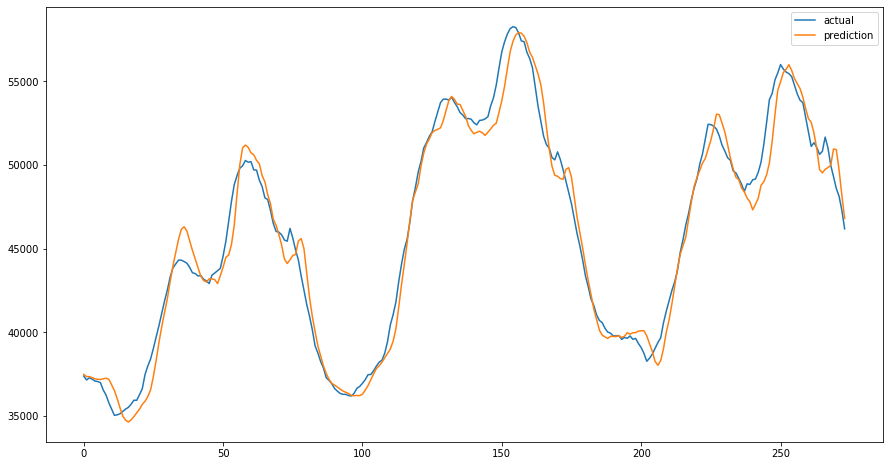

In [17]:
experiment2 = ExperimentForecast(6,before=2,drop_out=False)
experiment2.fit_predict_train()
experiment2.model_predict_test()
experiment2.plot_predict_comparison()

As the model skipped the most correlated first two lags, the model performance become bad. While keeping before argument with 2, we can increase the lagging steps. The next experiments will be done with expanding lags.

### Experiment 3
- lags: 12 (3 hours)
- before: 2

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28018 samples, validate on 6994 samples
Epoch 1/20
28018/28018 [==============================] - 6s 197us/step - loss: 0.0131 - val_loss: 0.0052
Epoch 2/20
28018/28018 [==============================] - 5s 179us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 3/20
28018/28018 [==============================] - 5s 164us/step - loss: 0.0023 - val_loss: 0.0030
Epoch 4/20
28018/28018 [==============================] - 5s 166us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/20
28018/28018 [==============================] - 5s 170us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/20
28018/28018 [==============================] - 5s 166us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/20
28018/28018 [==============================] - 5s 174us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/20
28018/28018 [==============================] - 5s 172us/step - loss: 

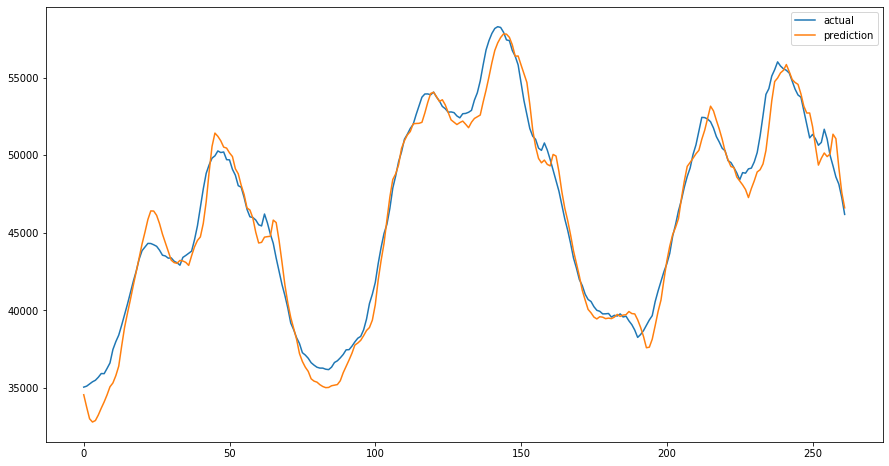

In [18]:
experiment3 = ExperimentForecast(4*3,before=2,drop_out=False)
experiment3.fit_predict_train()
experiment3.model_predict_test()
experiment3.plot_predict_comparison()

### Experiement 4
- lags: 24 (6 hours)
- before: 2

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28006 samples, validate on 6982 samples
Epoch 1/20
28006/28006 [==============================] - 10s 357us/step - loss: 0.0215 - val_loss: 0.0060
Epoch 2/20
28006/28006 [==============================] - 8s 296us/step - loss: 0.0035 - val_loss: 0.0032
Epoch 3/20
28006/28006 [==============================] - 9s 317us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/20
28006/28006 [==============================] - 9s 315us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/20
28006/28006 [==============================] - 9s 310us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/20
28006/28006 [==============================] - 8s 288us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/20
28006/28006 [==============================] - 9s 323us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/20
28006/28006 [==============================] - 9s 310us/step - loss:

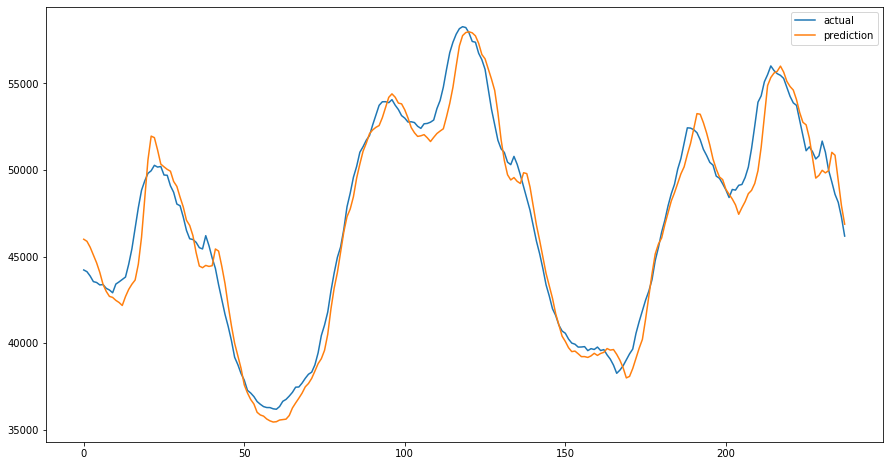

In [19]:
experiment4 = ExperimentForecast(4*6,before=2,drop_out=False)
experiment4.fit_predict_train()
experiment4.model_predict_test()
experiment4.plot_predict_comparison()

### Experiement 5
- lags: 48 (12 hours)
- before: 2

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 27982 samples, validate on 6958 samples
Epoch 1/20
27982/27982 [==============================] - 18s 636us/step - loss: 0.0189 - val_loss: 0.0029
Epoch 2/20
27982/27982 [==============================] - 16s 574us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/20
27982/27982 [==============================] - 16s 566us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/20
27982/27982 [==============================] - 16s 576us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/20
27982/27982 [==============================] - 16s 584us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
27982/27982 [==============================] - 16s 582us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
27982/27982 [==============================] - 18s 630us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/20
27982/27982 [==============================] - 16s 585us/step 

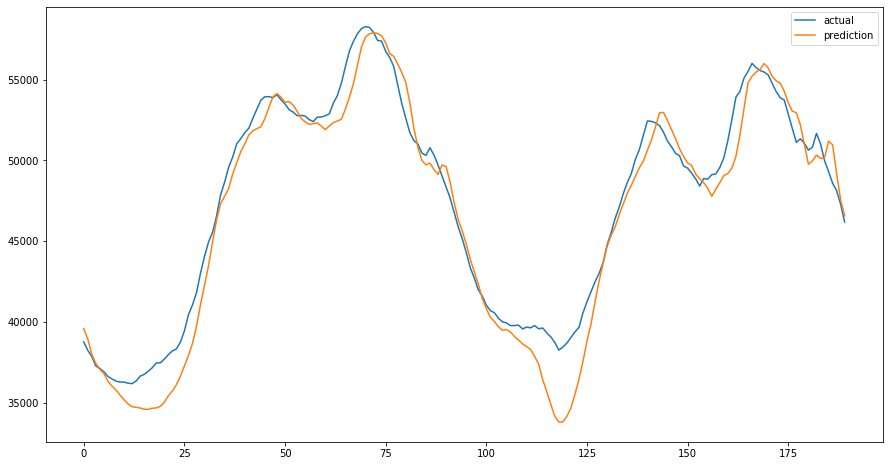

In [21]:
experiment5 = ExperimentForecast(4*12,before=2,drop_out=False)
experiment5.fit_predict_train()
experiment5.model_predict_test()
experiment5.plot_predict_comparison()

### Experiement 6
- lags: 24 (6 hours)
- before: 0

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28008 samples, validate on 6984 samples
Epoch 1/20
28008/28008 [==============================] - 9s 326us/step - loss: 0.0198 - val_loss: 0.0034
Epoch 2/20
28008/28008 [==============================] - 9s 307us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/20
28008/28008 [==============================] - 10s 374us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/20
28008/28008 [==============================] - 8s 299us/step - loss: 8.3365e-04 - val_loss: 9.7139e-04
Epoch 5/20
28008/28008 [==============================] - 9s 314us/step - loss: 6.5152e-04 - val_loss: 7.2946e-04
Epoch 6/20
28008/28008 [==============================] - 9s 322us/step - loss: 4.9190e-04 - val_loss: 5.3434e-04
Epoch 7/20
28008/28008 [==============================] - 9s 306us/step - loss: 3.7173e-04 - val_loss: 4.2283e-04
Epoch 8/20
28008/28008 [=======================

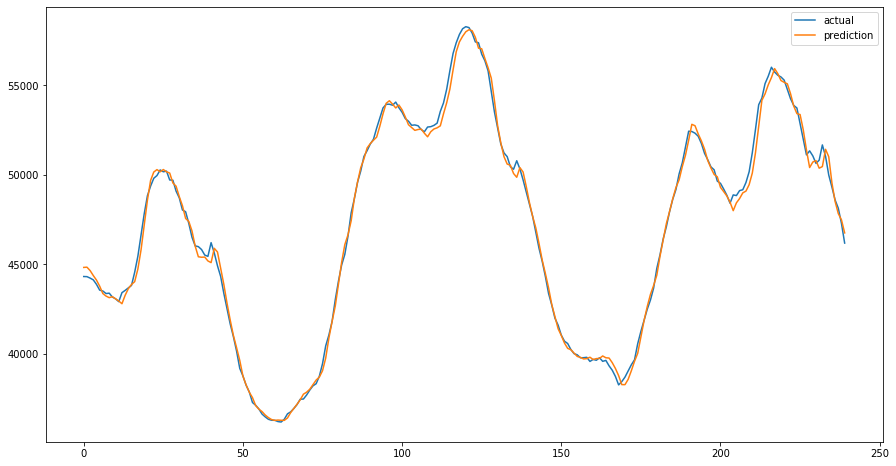

In [22]:
experiment6 = ExperimentForecast(4*6,before=0,drop_out=False)
experiment6.fit_predict_train()
experiment6.model_predict_test()
experiment6.plot_predict_comparison()

### Experiement 7
- lags: 24 (6 hours)
- before: 1

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28007 samples, validate on 6983 samples
Epoch 1/20
28007/28007 [==============================] - 9s 329us/step - loss: 0.0124 - val_loss: 0.0018
Epoch 2/20
28007/28007 [==============================] - 8s 302us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/20
28007/28007 [==============================] - 9s 313us/step - loss: 9.0692e-04 - val_loss: 0.0011
Epoch 4/20
28007/28007 [==============================] - 9s 333us/step - loss: 7.5928e-04 - val_loss: 8.2281e-04
Epoch 5/20
28007/28007 [==============================] - 9s 311us/step - loss: 6.7135e-04 - val_loss: 7.4206e-04
Epoch 6/20
28007/28007 [==============================] - 9s 322us/step - loss: 5.9551e-04 - val_loss: 6.8942e-04
Epoch 7/20
28007/28007 [==============================] - 9s 331us/step - loss: 5.4452e-04 - val_loss: 6.7443e-04
Epoch 8/20
28007/28007 [====================

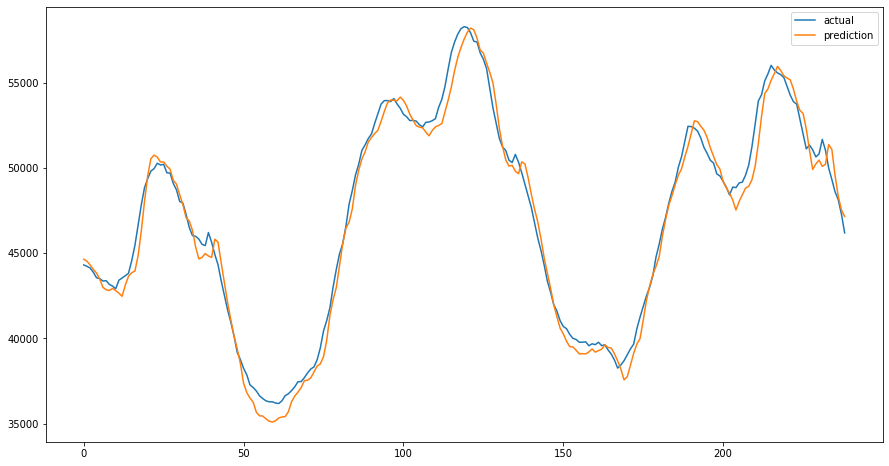

In [23]:
experiment7 = ExperimentForecast(4*6,before=1,drop_out=False)
experiment7.fit_predict_train()
experiment7.model_predict_test()
experiment7.plot_predict_comparison()

### Experiment8
- lags: 24 (6 hours)
- before: 3

The number of NaN values are 4 due to the start of summer time.
Now, the number of NaN values is 0 by deleting the skipped hour.
Train on 28005 samples, validate on 6981 samples
Epoch 1/20
28005/28005 [==============================] - 10s 346us/step - loss: 0.0096 - val_loss: 0.0066
Epoch 2/20
28005/28005 [==============================] - 8s 300us/step - loss: 0.0043 - val_loss: 0.0054
Epoch 3/20
28005/28005 [==============================] - 9s 309us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 4/20
28005/28005 [==============================] - 8s 299us/step - loss: 0.0025 - val_loss: 0.0035
Epoch 5/20
28005/28005 [==============================] - 9s 312us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/20
28005/28005 [==============================] - 9s 306us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/20
28005/28005 [==============================] - 8s 300us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 8/20
28005/28005 [==============================] - 10s 351us/step - loss

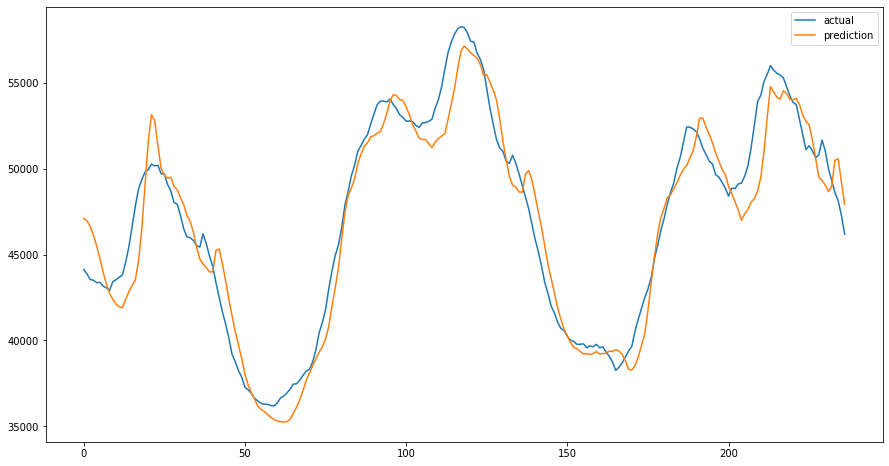

In [24]:
experiment8 = ExperimentForecast(4*6,before=3,drop_out=False)
experiment8.fit_predict_train()
experiment8.model_predict_test()
experiment8.plot_predict_comparison()

In [35]:
lstBylags = [experiment2,experiment3,experiment4,experiment5]
dictBylags = {}
for exprmt in lstBylags:
    key = exprmt.lags
    value = exprmt.rmsqrt_test
    dictBylags[key] = value

lstBybefore = [experiment6,experiment7,experiment4,experiment8]
dictBybefore = {}
for exprmt in lstBybefore:
    key = exprmt.before
    value = exprmt.rmsqrt_test
    dictBybefore[key] = value

In [33]:
dictBylags

{6: 1056.3673006789916,
 12: 1085.5143125032382,
 24: 1120.9915028453756,
 48: 1515.7927094181257}

In [40]:
dictBybefore

{0: 370.5417752395156,
 1: 807.4985973604673,
 2: 1120.9915028453756,
 3: 1604.6452739960168}

Text(0.5, 0, 'lags')

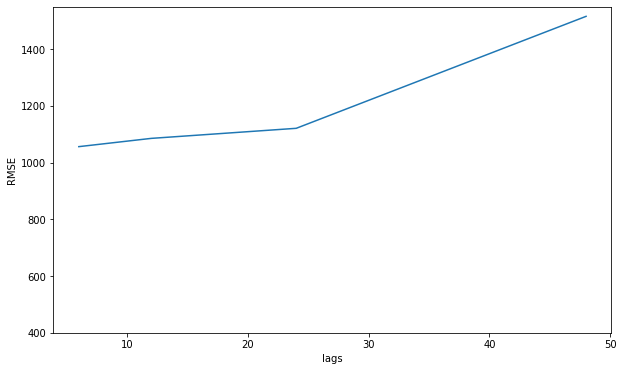

In [41]:
plt.figure(figsize=(10,6));
plt.plot(list(dictBylags.keys()),list(dictBylags.values()))
plt.ylim(400,1550)
plt.ylabel('RMSE')
plt.xlabel('lags')

Text(0.5, 0, 'before')

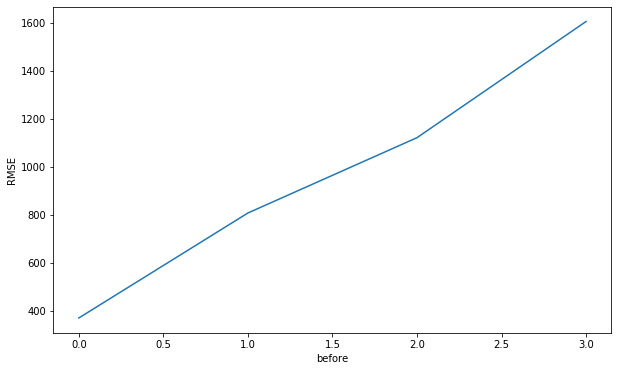

In [39]:
plt.figure(figsize=(10,6));
plt.plot(list(dictBybefore.keys()),list(dictBybefore.values()))
plt.ylabel('RMSE')
plt.xlabel('before')

### Interpreting the experiments

It seems that the number of lags is not crucial between 6 to 48 steps. Meanwhile, before argument has greater impact on the model performance. It can be interpreted from the partial correlogram which showed high correlations upto 5 time steps looking back. As the model could not consider the most recent data values (which means higher value of before), it is harder for the model to capture the trend of residuals. 

In order to enhence the model prediction, extra features like forecasting data can be introduced. The model developed in this project used only one feature which was the list of historic values. 

# Conclusion
It is required to predict electricity demand 30 minutes before the delivery in intraday market. As it needs to be predicted 30 minutes before, we cannot consider the most recent data. Still, the LSTM model shows good prediction with around 1000 MW of RMSE that can be predicted 45 minutes before the delivery. 

To predict more accurate load profile, extra features seem to be required rather than increasing the duration of looking back. Also, the model could be trained with data which is resampled into 30 minutes time step. 